## About Project

This project is to predict how various features like geographic location, weather conditions, type of vehicles etc. can be used to predict the severity of an accident. In other words, the project goal is to build a classification model for road accidents in UK to predict the Accident Severity.

##### This notebook demonstrates MCA dimension reduction and further model classifiers GaussianNB, poly SVM and Shallow Neural Network classifiers. SVC algorithm yields best results overall.

Data: Road accidents in UK between 2010 and 2014  
Link: https://www.kaggle.com/stefanoleone992/adm-project-road-accidents-in-uk  
Dataset: 75550 x 33  
Response: 0 : Slight and 1 : Fatal-Serious  

A classifier is built using 3 models- Naive Bayes, SVM and Neural Network for the task.
There are 2 parts to the process.
1. Data exploration, relevant teachniques from feature engineering, dimension reduction and feature selection are explored and implemented.
2. Data modeling based on Part 1 analysis, comparison of scores and final procedure selection for documentation. 

Metrics : Accuracy

### Overall Approach
We explored various data preparation and machine learning techniques:
##### 1.Data level
The various approaches to prepare data explored are explained in brief as we go along.
In general, amongst the various approaches tried, we talk about 2 approaches:
1. **Feature selection with Random Forest** at different variabilities (90%, 95%, 98%), with 95% yielding best accuracy scores overall.
2. **Dimension reduction technique with MCA** since the dataset is predominantly categorical with various n_components(5 to 22) with 22 yielding best accuracy scores overall. 

Both methods yield comparable results and we demonstrate method 2 here for the project which gives little better accuracy score.

##### 2.Classifier level
1. Since the dataset is large, stratified sampling technique is used with 50-50 train test split. 
2. Various relevant algorithms in classifiers paired with feature selection/reduction techniques were explored for instance, Gaussian, Categorical, Multinomial and Mixed for Naive Bayes, Linear,Poly and Rbf kernel for SVC and shallow and deep network for neural network.
3. Further, data modeling is done with hyperparameter tuning through k-fold grid search CV for all classifiers and accuracy score is reported on test set.
4. Threshold tuning(range 0.4 to 0.6) and found 0.55 threshold yielding best results for majority classifiers. 

**Notebook By:  
Swati Kohli  
Poonam Patil**

In [1]:
# Import Relevant Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# PreProcessing
from sklearn.preprocessing import LabelEncoder
import calendar

# Dimension Reduction
import prince
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Data Modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from tensorflow.random import set_seed
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Activation

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [2]:
# Load the dataset
road_accidents = pd.read_csv('RoadAccident.csv')
print(road_accidents.shape)
road_accidents.head()

(75550, 33)


,Accident_Index,Latitude,Longitude,Region,Urban_or_Rural_Area,X1st_Road_Class,Driver_IMD_Decile,Speed_limit,Road_Type,Road_Surface_Conditions,...,Junction_Detail,Junction_Location,X1st_Point_of_Impact,Driver_Journey_Purpose,Engine_CC,Propulsion_Code,Vehicle_Make,Vehicle_Category,Vehicle_Manoeuvre,Accident_Severity
0,1,51.495653,-0.179097,London,Urban,C,7,30,Single carriageway,Dry,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1781,Petrol,Audi,Car,Going ahead,Slight
1,2,51.499635,-0.209915,London,Urban,A,3,30,Single carriageway,Dry,...,More than 4 arms (not roundabout),Mid Junction - on roundabout or on main road,Offside,Other/Not known,2987,Heavy oil,Mercedes,Car,Waiting to go,Slight
2,3,51.492515,-0.168130,London,Urban,Unclassified,5,30,Single carriageway,Dry,...,Crossroads,Mid Junction - on roundabout or on main road,Front,Journey as part of work,998,Petrol,Nissan,Car,Going ahead,Slight
3,4,51.504784,-0.193863,London,Urban,A,2,30,Single carriageway,Dry,...,T or staggered junction,Mid Junction - on roundabout or on main road,Offside,Journey as part of work,2179,Heavy oil,Citroen,Van,Turning right,Slight
4,5,51.522072,-0.212927,London,Urban,B,3,30,Single carriageway,Wet or damp,...,T or staggered junction,Approaching junction or waiting/parked at junc...,Nearside,Journey as part of work,2198,Heavy oil,Ford,Van,Overtaking,Slight


In [3]:
# Preprocessing

# Binary encode target variable Accident_Severity
road_accidents['Accident_Severity'] = road_accidents['Accident_Severity'].map({'Fatal_Serious': 1, 'Slight': 0})
road_accidents['Accident_Severity'].value_counts() # Find distribution of classes

0    56705
1    18845
Name: Accident_Severity, dtype: int64

**Observation: There is a large class imbalance in the dataset with class 0 records approximately three times the class 1 records**

In [4]:
# Check for missing/NaN values
road_accidents.isnull().sum()

Accident_Index             0
Latitude                   0
Longitude                  0
Region                     0
Urban_or_Rural_Area        0
X1st_Road_Class            0
Driver_IMD_Decile          0
Speed_limit                0
Road_Type                  0
Road_Surface_Conditions    0
Weather                    0
High_Wind                  0
Lights                     0
Datetime                   0
Year                       0
Season                     0
Month_of_Year              0
Day_of_Month               0
Day_of_Week                0
Hour_of_Day                0
Number_of_Vehicles         0
Age_of_Driver              0
Age_of_Vehicle             0
Junction_Detail            0
Junction_Location          0
X1st_Point_of_Impact       0
Driver_Journey_Purpose     0
Engine_CC                  0
Propulsion_Code            0
Vehicle_Make               0
Vehicle_Category           0
Vehicle_Manoeuvre          0
Accident_Severity          0
dtype: int64

Observation: No missing values in the dataset

## Part 1
## Feature engineering
Diagnose features from the dataset and convert to appropriate categorical format.  
1. Three numerical features in the dataset are converted to categorical- Season, Month_of_Year and Day_of_Week.   
2. Further three more features-Age_of_Vehicle,Hour_of_Day and Engine_CC are transformed into categorical by binning. 
3. Unnecessary columns Latitude,Longitude, Datetime and Accident_Index are dropped since the locational and temporal features are engineered from them.

**Season, Month_of_Year and Day_of_Week are categorical features** though they are having numerical value. Hence convert it to categorical variable

In [5]:
# Convert multinomial features to categorical by converting to datatype string
road_accidents['Season'] = road_accidents['Season'].apply(str)
road_accidents['Month_of_Year'] = road_accidents['Month_of_Year'].apply(str)
road_accidents['Day_of_Week'] = road_accidents['Day_of_Week'].apply(str)

**Create categorical feature from Age_of_Vehicle**

In [6]:
road_accidents['Age_of_Vehicle_cat'] = pd.qcut(road_accidents['Age_of_Vehicle'], 
                                               [0,0.25,0.5,0.75,1], labels = ['new','average', 'old', 'very_old'])

**Create categorical feature from Hour_of_Day predictors**

In [7]:
road_accidents['Hour_of_Day_cat'] = pd.qcut(road_accidents['Hour_of_Day'], 
        [0,0.25,0.5,0.75,1], labels=['early_morning', 'morning', 'afternoon', 'night'])

**Create categorical feature from Engine_CC predictors**

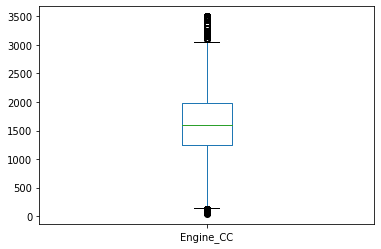

In [8]:
road_accidents['Engine_CC'].plot(kind = 'box')

Observation: There are outliers in the engine_cc predictor variable. Therefore convert it to categorical variable with 6 bins

In [9]:
road_accidents['Engine_CC'].describe()

count    75550.000000
mean      1571.622144
std        591.044815
min         38.000000
25%       1242.000000
50%       1596.000000
75%       1975.000000
max       3500.000000
Name: Engine_CC, dtype: float64

In [10]:
# calculate inter quartile range for Engine_CC
IQR = road_accidents['Engine_CC'].quantile(0.75) - road_accidents['Engine_CC'].quantile(0.25)

# calculate fences to detect outliers in Engine_CC predictor
fence1 = (1.5*IQR)+ road_accidents['Engine_CC'].quantile(0.75) # formula to find fences
fence2 = road_accidents['Engine_CC'].quantile(0.25)- (1.5*IQR)

print(fence1)
print(fence2)

# create categorical variable for Engine_CC
road_accidents['Engine_CC_cat'] = pd.cut(road_accidents['Engine_CC'], 
                                         bins = [0,142.5,1242,1596, 1975, 3074.5, 6599], # 6599cc is maximum available vehicle cc
                                         labels = ['CC1','CC2','CC3','CC4','CC5','CC6'])

3074.5
142.5


Since the features are already engineered for latitude and longitude as location details and datetime as temporal, they are irrelevant and can be dropped. Also, Accident_Index to be dropped.

In [11]:
# Delete original Age_of_Vehicle and Hour_of_Day, 'Engine_CC' variables from data and unnecessary columns
road_accidents.drop(['Age_of_Vehicle','Hour_of_Day','Engine_CC',
                     'Accident_Index', 'Latitude', 'Longitude','Datetime'],axis=1,inplace=True)

In [12]:
# Extract X and y
X = road_accidents.copy()
del X['Accident_Severity']
y=road_accidents['Accident_Severity']

### Stratefied K-fold sampling to create training and testing set

Apply Train Test split with StratifiedShuffleSplit with 50-50% (same split is followed throughout)

In [13]:
# Train Test split with stratified split 50-50%
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Part 1: Dimension Reduction
There are 6 numerical and 22 categorical features post preprosessing steps. Therefore, for all classifiers two approaches were explored and best results from feature selection/reduction implemented.
1. Use **Random Forest** for feature selection (with variability of approximately 95%).
2. Use **MCA** as a feature reduction technique, because of majority categorical features, to transform the categorical data to numerical data (n_components = 22).

Upon implementing various n_compenents(range 5-22), n_components = 22 gave overall best results. 

We demonstrate MCA dimension reduction approach
###  MCA approach on categorical features

In [14]:
# Define a function for seperating data types (numerical and non numerical)
'''
This function will separate the data into numerical and categorical/object type
'''
def separate(data):
    num = data.dtypes =='int64'
    cat = data.dtypes != 'int64'

    num = data[data.columns[num]]
    cat = data[data.columns[cat]]
    
    return num, cat

'''
This function will match the categorical features in the training set and testing set
Returns two cleaned data sets
'''
def cat_feat(train, test):
    # Make sure categorical features in both sets match
    # Make sure the training feature and testing feature has same number of levels
    keep = train.nunique() == test.nunique()
    train = train[train.columns[keep]]
    test = test[test.columns[keep]]

    # Make sure the levels are the same
    keep = []
    for i in range(train.shape[1]):
        keep.append(all(np.sort(train.iloc[:,i].unique()) == np.sort(test.iloc[:,i].unique())))
    train = train[train.columns[keep]]
    test = test[test.columns[keep]]
    return train, test

In [15]:
# Separate numerical and categorical features
X_train_num, X_train_cat = separate(X_train)
X_test_num, X_test_cat = separate(X_test)

# Make sure categorical features match between training and validation sets
X_train_cat, X_test_cat = cat_feat(X_train_cat, X_test_cat)

In [16]:
# Perform mca on categorical and then combine with numerical data

mca = prince.MCA(n_components = 22, random_state = 1) # Instantiate MCA

# On train set
X_train_cat_fs = mca.fit_transform(X_train_cat) # Fit and Transform on categorical train data
X_train_cat_fs = X_train_cat_fs.add_prefix('mca') # Add a prefix to reduced columns
X_train_fs = pd.concat([X_train_num, X_train_cat_fs], axis = 1) # Join numerical and reduced columns

# On test set
X_test_cat_fs = mca.transform(X_test_cat) # Transform on categorical test data
X_test_cat_fs = X_test_cat_fs.add_prefix('mca') # Add a prefix to reduced columns
X_test_fs = pd.concat([X_test_num, X_test_cat_fs], axis = 1) # Join numerical and reduced columns

y_train_fs = y_train.copy()
y_test_fs = y_test.copy()

## Part 2: Data Modeling

### Steps followed for all classifiers:
On MCA reduced dataset:
1. Setup Hyperparameter tuning 
2. Use 5 fold gridsearch CV to train and tune the data with classifier
3. Obtain best parameters on training and accuracy score on test set
4. On exploring certain threshold values for prediction, best accuracy was found at 0.55 for all classifiers. Therefore, same threshold is followed throughout.

### Classifier 1: Naive Bayes

#### Approach:
There are 6 numerical and 22 categorical features finally after preprocessing steps. Upon diagnosing the distribution of numerical features through a histogram plot, it shows they are multinomial and also by applying log transformation (and square transformation) it did not result in a normal distribution. Therefore, the numerical features are multinomial and we keep those features as is.  
Further for Naive Bayes classifier two approaches were explored and implemented.
1. Taking **all the categorical data** and perform prediction with **CategoricalNB** since majority data is categorical. (Accuracy: 0.7561)
2. Use **MCA** as a feature reduction technique (n_components = 22) to transform the categorical data to numerical and perform **GaussianNB** on entire dataset consisting of 6 numerical features and 22 mca transformed features. (Accuracy: 0.7556)

We demonstrate approach 2 here for consistency in preprocessing/feature engineering steps as the accuracy results are comparable.

#### Explorations on Naive Bayes:
1. For MCA n_components range tried (5-22). 
2. MCA with log transformation on features did not give better results.
3. CategoricalNB taking multinomial features as well and encoding them along with categorical features did not give better results.
4. RF feature selected GaussianNB accuracy 0.7497, multinomialNB accuracy 0.7259

In [17]:
#   ******** Model 1 : Classifier Naive Bayes with GaussianNB ******** 
# GaussianNB on MCA reduced dataset

# Hyperparameter tuning with accuracy as scoring
paras = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-01, 1],
        'priors':[None,[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.9,0.1],[0.8,0.2],[0.7,0.3]]} 

# Instantiate Gridsearch CV
GB_grid = GridSearchCV(GaussianNB(), paras, scoring = 'accuracy', cv = 2, n_jobs = -2)

# Fit the model
GB_grid.fit(X_train_fs, y_train_fs)

# Get the result
print("Best Params:",GB_grid.best_params_)

# Evaluation on test set with threshold 0.55
threshold=0.55
y_hat = np.where(GB_grid.predict_proba(X_test_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
conf_matrix = confusion_matrix(y_test_fs, y_hat, labels=[1,0])
print(conf_matrix)
print('Accuracy on GaussianNB with threshold 0.55:', np.mean(y_hat == y_test_fs))

Best Params: {'priors': [0.9, 0.1], 'var_smoothing': 1e-05}
[[  583  8840]
 [  389 27963]]
Accuracy on GaussianNB with threshold 0.55: 0.7556849768365321


### Classifier 2: Neural Network

Implemented shallow and deep neural network. Shallow network consistently gave better accuracy score

#### Explorations on NN:
1. RF feature selection with shallow NN accuracy: 0.7599  
2. RF feature selection with deep NN accuracy: 0.7505  
3. MCA dim reduction with deep NN accuracy: 0.7505

In [18]:
# Train Valid split with stratified split. Valid set to be used in Neural network model for validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
sss.get_n_splits(X_train_fs, y_train_fs)

for train_index, valid_index in sss.split(X_train_fs, y_train_fs):
    X_train1_fs, X_valid_fs = X_train_fs.iloc[train_index], X_train_fs.iloc[valid_index]
    y_train1_fs, y_valid_fs = y_train_fs.iloc[train_index], y_train_fs.iloc[valid_index]

In [19]:
# Scale data
scaler= StandardScaler()
X_train1_fs = scaler.fit_transform(X_train1_fs)
X_valid_fs = scaler.transform(X_valid_fs)
X_test_fs = scaler.transform(X_test_fs)

In [20]:
#   ******** Model 2 : Classifier NN ******** 
# Shallow neural network on MCA reduced dataset
set_seed(1)
seed(1)
# setup hyper parameter set
param = {'n_neurons':[4],
        'activations':['relu'],
        'l2_penalty':[0.01]}

n_input = X_train1_fs.shape[1]
optimizer = 'SGD'

# create a wrapper function
def tuning_model(n_neurons, activations, l2_penalty):
    model3 = Sequential() # Instantiate the model
    options = {"input_dim": n_input} # Set options 
    print(n_neurons)
    model3.add(Dense(n_neurons, activation = activations, **options, kernel_regularizer = l2(l2_penalty))) # Using the input options from before
    options = {} # Erase the input options so it won't be included in future layers
    model3.add(Dense(1, activation = 'sigmoid'))
    
    # compile the model
    model3.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics=['accuracy'])
    return model3

# Set up the grid search
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(tuning_model) 

grd_cv = GridSearchCV(keras_clf, param, cv = 2, n_jobs = -2)

# Fit the model
grd_cv.fit(X_train1_fs, y_train1_fs, epochs = 30, batch_size=32,
          validation_data = (X_valid_fs, y_valid_fs),
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='Val_loss', patience=3)) #Set early stopping criteria

print(grd_cv.best_params_)
threshold=0.5
y_hat = np.where(grd_cv.predict_proba(X_test_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
print('accuracy with threshold 0.5 is:', np.mean(y_hat == y_test_fs))

4
Epoch 1/30
591/591 [==============================] - 1s 1ms/step - loss: 0.6768 - accuracy: 0.6913 - val_loss: 0.6104 - val_accuracy: 0.7482
Epoch 2/30
591/591 [==============================] - 1s 975us/step - loss: 0.5970 - accuracy: 0.7500 - val_loss: 0.5861 - val_accuracy: 0.7501
Epoch 3/30
591/591 [==============================] - 1s 991us/step - loss: 0.5795 - accuracy: 0.7506 - val_loss: 0.5722 - val_accuracy: 0.7510
Epoch 4/30
591/591 [==============================] - 1s 1ms/step - loss: 0.5678 - accuracy: 0.7519 - val_loss: 0.5623 - val_accuracy: 0.7524
Epoch 5/30
591/591 [==============================] - 1s 982us/step - loss: 0.5589 - accuracy: 0.7536 - val_loss: 0.5546 - val_accuracy: 0.7538
Epoch 6/30
591/591 [==============================] - 1s 990us/step - loss: 0.5519 - accuracy: 0.7539 - val_loss: 0.5486 - val_accuracy: 0.7549
Epoch 7/30
591/591 [==============================] - 1s 977us/step - loss: 0.5467 - accuracy: 0.7551 - val_loss: 0.5440 - val_accuracy: 0

Epoch 23/30
591/591 [==============================] - 1s 963us/step - loss: 0.5288 - accuracy: 0.7582 - val_loss: 0.5274 - val_accuracy: 0.7593
Epoch 24/30
591/591 [==============================] - 1s 972us/step - loss: 0.5286 - accuracy: 0.7587 - val_loss: 0.5271 - val_accuracy: 0.7593
Epoch 25/30
591/591 [==============================] - 1s 989us/step - loss: 0.5285 - accuracy: 0.7580 - val_loss: 0.5268 - val_accuracy: 0.7597
Epoch 26/30
591/591 [==============================] - 1s 960us/step - loss: 0.5283 - accuracy: 0.7584 - val_loss: 0.5271 - val_accuracy: 0.7591
Epoch 27/30
591/591 [==============================] - 1s 963us/step - loss: 0.5282 - accuracy: 0.7585 - val_loss: 0.5263 - val_accuracy: 0.7594
Epoch 28/30
591/591 [==============================] - 1s 994us/step - loss: 0.5280 - accuracy: 0.7578 - val_loss: 0.5267 - val_accuracy: 0.7589
Epoch 29/30
591/591 [==============================] - 1s 975us/step - loss: 0.5279 - accuracy: 0.7581 - val_loss: 0.5259 - val_ac

In [21]:
"""
#   ******** Model 2 : Classifier NN ******** 
# Shallow neural network on MCA reduced dataset
set_seed(1)
seed(1)
# setup hyper parameter set
param = {'n_neurons':[4,5,7,10],
        'activations':['relu'],
        'l2_penalty':[0.1, 0.01]}

n_input = X_train1_fs.shape[1]
optimizer = 'SGD'

# create a wrapper function
def tuning_model(n_neurons, activations, l2_penalty):
    model3 = Sequential() # Instantiate the model
    options = {"input_dim": n_input} # Set options 
    print(n_neurons)
    model3.add(Dense(n_neurons, activation = activations, **options, kernel_regularizer = l2(l2_penalty))) # Using the input options from before
    options = {} # Erase the input options so it won't be included in future layers
    model3.add(Dense(1, activation = 'sigmoid'))
    
    # compile the model
    model3.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics=['accuracy'])
    return model3

# Set up the grid search
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(tuning_model) 

grd_cv = GridSearchCV(keras_clf, param, cv = 2, n_jobs = -2)

# Fit the model
grd_cv.fit(X_train1_fs, y_train1_fs, epochs = 30, batch_size=32,
          validation_data = (X_valid_fs, y_valid_fs),
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='Val_loss', patience=3)) #Set early stopping criteria

print(grd_cv.best_params_)
threshold=0.55
y_hat = np.where(grd_cv.predict_proba(X_test_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
print('accuracy with threshold 0.55 is:', np.mean(y_hat == y_test_fs))
"""

'\n#   ******** Model 2 : Classifier NN ******** \n# Shallow neural network on MCA reduced dataset\nset_seed(1)\nseed(1)\n# setup hyper parameter set\nparam = {\'n_neurons\':[4,5,7,10],\n        \'activations\':[\'relu\'],\n        \'l2_penalty\':[0.1, 0.01]}\n\nn_input = X_train1_fs.shape[1]\noptimizer = \'SGD\'\n\n# create a wrapper function\ndef tuning_model(n_neurons, activations, l2_penalty):\n    model3 = Sequential() # Instantiate the model\n    options = {"input_dim": n_input} # Set options \n    print(n_neurons)\n    model3.add(Dense(n_neurons, activation = activations, **options, kernel_regularizer = l2(l2_penalty))) # Using the input options from before\n    options = {} # Erase the input options so it won\'t be included in future layers\n    model3.add(Dense(1, activation = \'sigmoid\'))\n    \n    # compile the model\n    model3.compile(loss = \'binary_crossentropy\', optimizer = \'SGD\', metrics=[\'accuracy\'])\n    return model3\n\n# Set up the grid search\nkeras_clf = t

### Classifier 3: SVM
Implemented LinearSVC, SVC with kernel poly and rbf. 
SVC with kernel poly consistently gave better results across all three types of SVC classifiers.

#### Explorations on SVM:
1. For MCA n_components range tried (5-22). 
2. SVC poly on RF feature selected and threshold 0.55 accuracy: 0.7601 (conventional train test split method)

In [22]:
#   ******** Model 3 : Classifier SVC with kernel poly ******** 
# SVC kernel poly on MCA reduced dataset

# Setup pipeline
svm_clf = Pipeline([
                    ('scalar', StandardScaler()),
                    ('poly', SVC(kernel = 'poly', random_state = 1, probability=True))
                    ])

# Setup parameters to tune
parameters = {'poly__C':[0.1],
             'poly__degree':[3],
             'poly__coef0':[2]}

svm_poly = GridSearchCV(svm_clf, parameters, cv=5, n_jobs = -2)

# Fit the model
svm_poly.fit(X_train_fs, y_train_fs) 

print("Best Params:",svm_poly.best_params_)

# Evaluation on test set with threshold 0.55
threshold=0.55
y_hat = np.where(svm_poly.predict_proba(X_test_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
print('Accuracy on SVC poly with threshold 0.55:', np.mean(y_hat == y_test_fs))

Best Params: {'poly__C': 0.1, 'poly__coef0': 2, 'poly__degree': 3}
Accuracy on SVC poly with threshold 0.55: 0.750549305095963


## Code to predict on unseen data

In [23]:

def process_new_file(X_unseen,X_train_cat ):
    
# Step 1. Preprocess 
    # Convert multinomial features to categorical by converting to datatype string
    
    X_unseen['Season'] = X_unseen['Season'].apply(str)
    X_unseen['Month_of_Year'] = X_unseen['Month_of_Year'].apply(str)
    X_unseen['Day_of_Week'] = X_unseen['Day_of_Week'].apply(str)

    # Create categorical feature from Age_of_Vehicle
    X_unseen['Age_of_Vehicle_cat'] = pd.qcut(X_unseen['Age_of_Vehicle'], 
                                                   [0,0.25,0.5,0.75,1], labels = ['new','average', 'old', 'very_old'])

    # Create categorical feature from Hour_of_Day predictors
    X_unseen['Hour_of_Day_cat'] = pd.qcut(X_unseen['Hour_of_Day'], 
            [0,0.25,0.5,0.75,1], labels=['early_morning', 'morning', 'afternoon', 'night'])

    X_unseen['Engine_CC_cat'] = pd.cut(X_unseen['Engine_CC'], 
                                             bins = [0,142.5,1242,1596, 1975, 3074.5, 6599],
                                             labels = ['CC1','CC2','CC3','CC4','CC5','CC6'])

    # Delete original Age_of_Vehicle, Hour_of_Day, Engine_CC variables and unnecessary columns from data
    X_unseen.drop(['Accident_Index', 'Latitude', 'Longitude','Datetime','Age_of_Vehicle','Hour_of_Day', 'Engine_CC'],
                  axis=1,inplace=True)




# Step 2. MCA dim reduction
    # Separate numerical and categorical features
    X_new_num, X_new_cat = separate(X_unseen)
    # Make sure categorical features match between training and validation sets
    X_train_cat, X_new_cat = cat_feat(X_train_cat, X_new_cat)
    X_new_cat_fs = mca.transform(X_new_cat) # Transform on categorical test data
    X_new_cat_fs = X_new_cat_fs.add_prefix('mca') # Add a prefix to reduced columns
    X_new_fs = pd.concat([X_new_num, X_new_cat_fs], axis = 1) # Join numerical and reduced columns




## Step 3. Prediction on X_test_fs set and return output dataframe
    threshold=0.55 # set threshold
    
    # Classifier 1: Naive Bayes- GaussianNB
    y_hat_gb = np.where(GB_grid.predict_proba(X_new_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
    
    # Classifier 2: Neural Network- shallow 
    X_new_fs_nn = scaler.transform(X_new_fs)
    threshold2 = 0.5
    y_hat_nn = np.where(grd_cv.predict_proba(X_new_fs_nn)[:,1] > threshold2, 1, 0) # Get the predicted classes
    
    # Classifier 3: SVM- kernel poly
    y_hat_svm = np.where(svm_poly.predict_proba(X_new_fs)[:,1] > threshold, 1, 0) # Get the predicted classes
    
    
   # Return Dataframe with the predictions
    data_features = list(zip(y_hat_svm,y_hat_nn,y_hat_gb))
    df = pd.DataFrame(data_features, columns = ['SVM','NN','NB'])
    return df




# Read unseen new file
X_new = pd.read_csv('test_small.csv')
predicted = process_new_file(X_new.copy(),X_train_cat)

# Binary decode target variable of Accident_Severity
# 'Fatal_Serious': 1, 'Slight': 0
predicted.replace(to_replace = 0, value ='Slight', inplace=True)
predicted.replace(to_replace = 1, value ='Fatal_Serious',inplace=True)
predicted.insert(0, 'Accident_Index', X_new['Accident_Index']) # Add Accident_Index Column

# Export predicted df to csv
predicted.to_csv('submission_small.csv', index = False)
print(predicted.shape)
predicted
"""
"""

(70000, 4)


'\n'

In [24]:
predicted

,Accident_Index,SVM,NN,NB
0,1,Slight,Slight,Slight
1,2,Fatal_Serious,Slight,Fatal_Serious
2,3,Slight,Slight,Slight
3,4,Slight,Slight,Slight
4,5,Slight,Slight,Slight
...,...,...,...,...
69995,69996,Slight,Slight,Slight
69996,69997,Slight,Slight,Slight
69997,69998,Slight,Slight,Slight
69998,69999,Slight,Slight,Slight


In [25]:
predicted.NN.value_counts()

Slight           67945
Fatal_Serious     2055
Name: NN, dtype: int64

In [26]:
predicted.SVM.value_counts()

Slight           68131
Fatal_Serious     1869
Name: SVM, dtype: int64

In [27]:
predicted.NB.value_counts()

Slight           68216
Fatal_Serious     1784
Name: NB, dtype: int64

In [2]:
sub = pd.read_csv('submission_small.csv')
sub

,Accident_Index,SVM,NN,NB
0,1,Slight,Slight,Slight
1,2,Fatal_Serious,Slight,Fatal_Serious
2,3,Slight,Slight,Slight
3,4,Slight,Slight,Slight
4,5,Slight,Slight,Slight
...,...,...,...,...
69995,69996,Slight,Slight,Slight
69996,69997,Slight,Slight,Slight
69997,69998,Slight,Slight,Slight
69998,69999,Slight,Slight,Slight


In [3]:
subr = pd.read_csv('test_label_small.csv')
subr

,Accident_Index,Accident_Severity
0,1,Slight
1,2,Fatal_Serious
2,3,Fatal_Serious
3,4,Slight
4,5,Slight
...,...,...
69995,69996,Slight
69996,69997,Fatal_Serious
69997,69998,Fatal_Serious
69998,69999,Slight


### Accuracy Metric
1. SVM : 0.7575571  
2. Neural Network : 0.7558714  
3. Naive Bayes : 0.7527714  

**Poly kernel SVC algorithm shows best result overall.**